# Exercise Set 12: Peer effects 


In this Exercise Set 12 we will investigate peer effects data. 

## 12.1: roommate peer effects


<br>
<br>

We use a simlated dataset which will give results that provide conclusions similar to Sacerdote (2000). 

### Data structuring 

Our data set does not contain a network but has an implicit one associated. We assume there is an edge between all room mates. 

> **Ex. 12.1.1:** Create a column called `person_other` with identity of the other person in room.
>> *Hint:* You can get the unique people in the room by using `df.groupby('room').person.unique()`.

In [2]:
# Load data
import pandas as pd

data = pd.read_csv("peer_effects_room.csv")
print('Showing dimension of the dataframe:',data.shape)

# Visualizing the dataframe
data.head()

Showing dimension of the dataframe: (2000, 4)


,person,room,high_school_GPA,college_GPA
0,0,351,-1.715472,-1.285307
1,1,738,-0.530190,-0.031833
2,2,247,-0.589543,-0.203230
3,3,751,-1.303115,0.982488
4,4,698,0.156678,-0.371632


In [3]:
# Creating dataframe with persons in rooms (1000 rooms with 2 in each)
unique = pd.DataFrame(data.groupby('room').person.unique())
unique[['1','2']] = pd.DataFrame(unique.person.tolist(), index= unique.index)
unique = unique.drop(columns='person')

# Setting index to person to match index of the data dataframe. No double dounts so we need to split up into two data frames
unique1 = unique.set_index('1')
unique1 = unique1.sort_index(ascending=True)
unique2 = unique.set_index('2')
unique2 = unique2.sort_index(ascending=True)

# merge data in the two data frames
data1 = data.merge(unique1, left_index=True, right_index=True)
data1 = data1.rename(columns={'2': 'person_other'})

data2 = data.merge(unique2, left_index=True, right_index=True)
data2 = data2.rename(columns={'1': 'person_other'})

# Visualizing the dataframe
df_full = pd.concat([data1, data2], axis=0, ignore_index=True)
df_full.head()

,person,room,high_school_GPA,college_GPA,person_other
0,0,351,-1.715472,-1.285307,1645
1,1,738,-0.530190,-0.031833,1039
2,2,247,-0.589543,-0.203230,944
3,3,751,-1.303115,0.982488,1099
4,4,698,0.156678,-0.371632,1708


<br>

> **Ex. 12.1.2:** Add information on the roommate GPA in high school and college.
>> *Hint:* This can be done merging on `person_other`.

In [4]:
# Creating dataframe with person and high school pga
gpa = df_full[['person','high_school_GPA', 'college_GPA']] #
gpa = gpa.rename(columns={'person': 'person_other'})  # rename person to person_other such that we can apply the column as key in merge
gpa = gpa.rename(columns={'high_school_GPA': 'high_school_GPA_roommate'}) # renaming such that we avoid the suffix of _x and _y
gpa = gpa.rename(columns={'college_GPA': 'college_GPA_roommate'}) 

# adding the column of roommate high school gpa with pd.merge 
df_full = pd.merge(df_full,gpa[['person_other','high_school_GPA_roommate','college_GPA_roommate']],on='person_other', how='left')
df_full.head()


,person,room,high_school_GPA,college_GPA,person_other,high_school_GPA_roommate,college_GPA_roommate
0,0,351,-1.715472,-1.285307,1645,-0.818594,-0.434847
1,1,738,-0.530190,-0.031833,1039,-0.493444,0.299729
2,2,247,-0.589543,-0.203230,944,1.281112,-0.479543
3,3,751,-1.303115,0.982488,1099,-1.812137,-2.267394
4,4,698,0.156678,-0.371632,1708,-0.327219,0.670683


<br>
<br>

### Data exploration and randomization

We now have our final dataset and can begin investigating how the raw data looks. 

> **Ex. 12.1.3:** plot own GPA in high school vs college in a scatter plot.

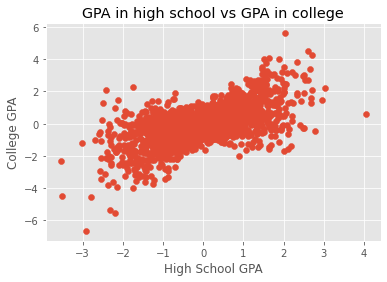

In [6]:
import matplotlib.pyplot as plt
import matplotlib.style
plt.style.use('ggplot')

# Defining the series
high_school_gpa = df_full['high_school_GPA']
college_gpa     = df_full['college_GPA']

# Plotting
plt.scatter(high_school_gpa, college_gpa)
plt.title('GPA in high school vs GPA in college')
plt.xlabel('High School GPA')
plt.ylabel('College GPA')
plt.show()

# Scatter plot show us a linear relationship as expected - indicates high correlation on performance in high school vs college

<br>
We want to check there is random assignment of roommates. 

> **Ex. 12.1.4:** Plot high school GPA vs roommate's high school GPA. Comment on the output. Run a regresion of high school GPA on roommate's high school GPA to formally check random assignment.
>
>> *Hint*: To run regressions in python, you can use the `statsmodels` package. Look up it's documentation and use the `.formula` api to estimate your model. To see a summary of a fitted model you can call `.summary()` on the object. 
>
>> *Hint:* Under random assignment we would expect there to be no relation between the high school GPA's of roommates. Why is this? 

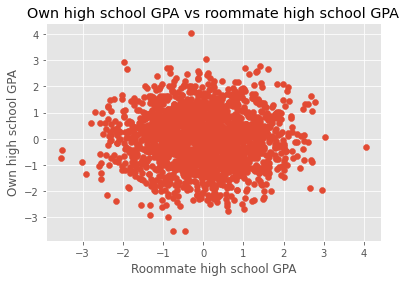

In [23]:
# Plotting high school GPA vs roommate's high school GPA

own = df_full['high_school_GPA']
roommate = df_full['high_school_GPA_roommate']

plt.scatter(roommate,own)
plt.title('Own high school GPA vs roommate high school GPA')
plt.xlabel('Roommate high school GPA')
plt.ylabel('Own high school GPA')
plt.show()

# We see a clear random assignment - no obvious correlation
# This is positive for the further analysis as we can interpret this as a true random group without self-selection (correlation)

In [19]:
# We run a regresion of high school GPA on roommate's high school GPA to formally check random assignment

import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd

df = pd.concat([pd.DataFrame(own), pd.DataFrame(roommate)], axis=1, sort=False)

# Run the model
mod = smf.ols(formula='own ~ roommate', data=df)
res = mod.fit()
print(res.summary())

# we notice that the roommate coefficient is almost zero and the t-statistics indicate that we cannot reject the null of 
# it being zero -> This is in favor of our hypothesis random assignment (no correlation)
# This is the case, since if the coefficient on roommate gpa was significantly different from zero (and postive), then 
# this would indicate "correlation" which would harm the inditification and/or omitted variable bias when testing for 
# peer effects. As adressed in the lecture video, then with correlation present, then we cannot answer the
# following regarding frienships (with people that are similar) 
# -> Are we similar because we are friends or are we friends because we are similar
# (where the first being incidating a peer effect and the latter the "correlation" problem)

                            OLS Regression Results                            
Dep. Variable:                    own   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.07263
Date:                Wed, 20 May 2020   Prob (F-statistic):              0.788
Time:                        15:37:03   Log-Likelihood:                -2883.6
No. Observations:                2000   AIC:                             5771.
Df Residuals:                    1998   BIC:                             5782.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0284      0.023     -1.241      0.2

<br>
<br>

## Roommate effect

Having checked the data we move on to analyzing peer effects. We begin with analyzing **exogenous** peer effects. I.e. peer effects that are related to the ex ante characteristics of the roommate.

> **Ex. 12.1.5:** Plot own GPA in college vs. roommate GPA in high school. Comment on the output. Test whether there is an impact using a regresion of college school GPA on high school GPA for the person itself and its roommate.

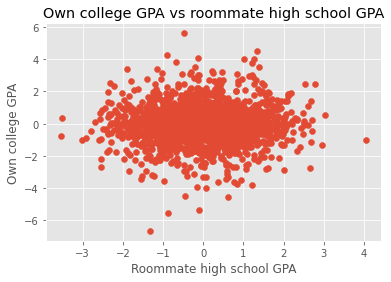

In [22]:
# Plotting to visualize potential exogenous peer effecets in own gpa in college cs roommate gpa in high school
# (thus, plotting own behavior vs peer (ex ante) characteristics)

own_college = df_full['college_GPA']
roommate_high_school = df_full['high_school_GPA_roommate']

plt.scatter(roommate_high_school,own_college)
plt.title('Own college GPA vs roommate high school GPA')
plt.xlabel('Roommate high school GPA')
plt.ylabel('Own college GPA')
plt.show()

In [24]:
# Running the regression of own behavir on exogenous peer effects (high school gpa)

# We run a regresion of high school GPA on roommate's high school GPA to formally check random assignment

import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd

df = pd.concat([pd.DataFrame(own_college), pd.DataFrame(roommate_high_school)], axis=1, sort=False)

# Run the model
mod = smf.ols(formula='own_college ~ roommate_high_school', data=df)
res = mod.fit()
print(res.summary())


# We do not see any particular effect -> no significant peer effect

                            OLS Regression Results                            
Dep. Variable:            own_college   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.584
Date:                Wed, 20 May 2020   Prob (F-statistic):              0.208
Time:                        16:09:15   Log-Likelihood:                -3099.5
No. Observations:                2000   AIC:                             6203.
Df Residuals:                    1998   BIC:                             6214.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.0427 

We now move on to analyze **endogenous** peer effects.

> **Ex. 12.1.6:** Test whether there is an association between own college GPA and roommates. Do this by running a regresion of college school GPA on high school GPA for the person itself and its roommate. Comment on the output.

In [27]:
# We now analyse for endogenous peer effects (thus, we include an extra varible compared to the regression in 12.1.5)
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd


own_college = df_full['college_GPA']
roommate_high_school = df_full['high_school_GPA_roommate']
own_high_school = df_full['high_school_GPA']


df = pd.concat([pd.DataFrame(own_college), pd.DataFrame(roommate_high_school), pd.DataFrame(own_high_school)], axis=1, sort=False)

# Run the model
mod = smf.ols(formula='own_college ~ roommate_high_school + own_high_school', data=df)
res = mod.fit()
print(res.summary())

# We observe a borderline significant exogenous peer effect (+0.0356) and a very clear postive endogenous peer effect (+0.7059)

                            OLS Regression Results                            
Dep. Variable:            own_college   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     671.3
Date:                Wed, 20 May 2020   Prob (F-statistic):          1.03e-223
Time:                        18:38:56   Log-Likelihood:                -2586.0
No. Observations:                2000   AIC:                             5178.
Df Residuals:                    1997   BIC:                             5195.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.0226 

<br>
<br>

# 12.2 Peer effects in Danish classrooms

Read the [report by Kraka on peer effects in Danish schools](http://kraka.dk/sites/default/files/public/baggrundsnotat_klassekammerateffekter_0.pdf) from 2019. If you do not speak Danish talk to your group about the content.
> **Ex. 12.2.1:** Explain the identification strategy in words.

The report by Deloitte / Kraka "Hvad betyder klassekammeraterne for det enkelte barns fremtid" follows the estimation procedures presented in Hoxby (2000), Lavy and Schlosser (2011) and Andersen (2015).

It is stated that the main identification problem in the estimation process in the selection proble. The issue of pontetially high ability students living in neighborhoods with other "high ability" families such that high ability students in the same classes etc. 

To overcome this potential issue, then estimation process introduces natural variation in the composition of classes and espcially in schools as they introduce time-varying variables. And instead of focusing on the single class, they consider schools over time. 

Furthermore, they apply \bar(X)_{ist} as a average of explainatory variables based on the "leave one out means" -> this is an inditification strategy reflected in the reflection problem -> Theory states that the inclusion mean leads to non-identification where exclusion means is identifiable.

> **Ex. 12.2.2:** Are there any shortcomings of the identification strategy? What does the seminal paper [Hoxby (2000)](https://www.nber.org/papers/w78612.pdf) test for?

The report follows the same approach as Hoxby (2000), where natural variation is introduced by time-varying estimation based on schools and not on class rooms. The approach introduces noise in the estimation and extra uncertainty of the estimates are considered. However, the consistency of the estiatamtes are still intact and the estimates can be applied on the class room level as well. Further, to compare with Hoxby (2000) paper, then dummy variables for the school finxed effects and year dummies are introduced to account for "overall ability" of years and schools. An example of this could be if a higher fraction of low-ability students in one year or school caused the "high ability" homes to take out their children of the public schools for the purpose of sending them to private schools. 

> **Ex. 12.2.3:** Try to come up with identification strategies for identifying peer effects in the context of Danish class rooms.

A potential identification strategy could be based on non-linear effects where a study could follow the precedure presented in "Ability Peer Effects in University: Evidence from a Randomized Experiment" (Booij, Leuven, Oosterbeek (2017)). Instead of using study groups on a university level, one could form class-room composition in Danish high schools based on the GPA of the public/private elementary schools.

However, there are clear ethical dilemmas in this strategy. 